In [1]:
import numpy as np
import pickle

with open('cache/traintest.pkl', 'rb') as f:
    df_train, df_test, train_y = pickle.load(f)
    
with open('cache/traintest_decomposition2_50.pkl', 'rb') as f:
    out50_train, out50_test = pickle.load(f)
        
with open('cache/non_zero_stats.pkl', 'rb') as f:
    agg_train, agg_test = pickle.load(f)        

In [2]:
from sklearn.feature_selection import VarianceThreshold    
import pandas as pd
from sklearn import preprocessing, model_selection, metrics

import lightgbm as lgb
import xgboost as xgb


In [3]:
df_train.shape, out50_train.shape, agg_train.shape

((4459, 4735), (4459, 100), (4459, 18))

In [4]:
def _to_ignore(df_train):
    def low_variance(df_train):
        s = VarianceThreshold(threshold=.0)
        s.fit(df_train)
        idxs = s.get_support()
        to_remove = [c for c, x in zip(df_train.columns, idxs) if not x]
        return to_remove

    def nunique(df_train):
        _, index = np.unique(df_train.values, return_index=True, axis=1)
        return [c for idx, c in enumerate(df_train.columns) if idx not in index]

    def suspicious(df_train):
        # drop zero fraction
        thr = 0.98
        to_ignore = []
        for column in df_train.columns:
            counts = df_train[column].value_counts()
            value_fraction = counts[0] / len(df_train)
            if value_fraction >= thr:
                to_ignore.append(column)
        return to_ignore

    to_ignore = set()
    to_ignore |= set(low_variance(df_train))
    to_ignore |= set(nunique(df_train))
    to_ignore |= set(suspicious(df_train))
    return to_ignore

from sklearn.feature_selection import VarianceThreshold    
from sklearn import preprocessing, model_selection, metrics

to_ignore = _to_ignore(df_train)
features = [c for c in df_train if c not in to_ignore]

In [5]:
print(len(features))

2121


In [6]:
original = [
    'f190486d6',
    '58e056e12',
    '58e2e02e6',
    '15ace8c9f',
    'fc436be29',
    '9fd594eec',
    'b6fa5a5fd',
    'eeb9cd3aa',
]

In [7]:
for c in original:
    print(c, np.max(df_train[c]), np.max(df_test[c]))

f190486d6 319612000.0 200000000.0
58e056e12 319612000.0 343333340.0
58e2e02e6 319612000.0 343333340.0
15ace8c9f 319612000.0 270074900.0
fc436be29 130000000.0 174891420.0
9fd594eec 115538000.0 343333340.0
b6fa5a5fd 200000000.0 279597950.0
eeb9cd3aa 319612000.0 336784540.0


In [8]:
df_train[original].corr()

,f190486d6,58e056e12,58e2e02e6,15ace8c9f,fc436be29,9fd594eec,b6fa5a5fd,eeb9cd3aa
f190486d6,1.000000,0.214752,0.242988,0.203771,-0.004452,0.288258,0.020651,0.229428
58e056e12,0.214752,1.000000,0.221408,0.266942,-0.004367,0.295572,0.003456,0.214775
58e2e02e6,0.242988,0.221408,1.000000,0.224111,-0.003110,0.248266,-0.003843,0.241182
15ace8c9f,0.203771,0.266942,0.224111,1.000000,-0.014206,0.286573,0.004396,0.247367
fc436be29,-0.004452,-0.004367,-0.003110,-0.014206,1.000000,0.002263,0.007941,-0.008515
9fd594eec,0.288258,0.295572,0.248266,0.286573,0.002263,1.000000,0.030259,0.300301
b6fa5a5fd,0.020651,0.003456,-0.003843,0.004396,0.007941,0.030259,1.000000,0.004249
eeb9cd3aa,0.229428,0.214775,0.241182,0.247367,-0.008515,0.300301,0.004249,1.000000


In [9]:
import scipy
from tqdm import tqdm

In [10]:
def build_stats(df_train, df_test, columns):
    out_train = pd.DataFrame()
    out_test = pd.DataFrame()
    
    df_all = pd.concat([df_train[columns], df_test[columns]]).astype(np.float32)
    
    for c in tqdm(columns):
        _, _, bin_idx = scipy.stats.binned_statistic(df_all[c], df_all[c], bins=10)        
        out_train[f"{c}_bin"] = bin_idx[:df_train.shape[0]]
        out_test[f"{c}_bin"] = bin_idx[df_train.shape[0]:]
        
        rank = scipy.stats.rankdata(df_all[c]) / len(df_all)
        out_train[f"{c}_rank"] = rank[:df_train.shape[0]]
        out_test[f"{c}_rank"] = rank[df_train.shape[0]:]
        
        #no good
        #zscore = scipy.stats.rankdata(df_all[c])
        #out_train[f"{c}_zscore"] = zscore[:df_train.shape[0]]
        #out_test[f"{c}_zscore"] = zscore[df_train.shape[0]:]
        
    return out_train, out_test
     
        
    

In [11]:
stats1_train, stats1_test = build_stats(df_train, df_test, original)

100%|██████████| 8/8 [00:00<00:00, 49.28it/s]


In [12]:
import pandas as pd
from scipy.stats import skew, kurtosis

def quantile(x, q):
    return np.percentile(x, q=q)

def build_stats2(df_train, df_test):
    def aggregate_row(row):
        non_zero_values = row.iloc[row.nonzero()].dropna(how='all')
        aggs = {'non_zero_mean2': non_zero_values.mean(),
                'non_zero_std2': non_zero_values.std(),
                'non_zero_max2': non_zero_values.max(),
                'non_zero_min2': non_zero_values.min(),
                'non_zero_sum2': non_zero_values.sum(),
                'non_zero_skewness2': skew(non_zero_values),
                'non_zero_kurtosis2': kurtosis(non_zero_values),
                'non_zero_median2': non_zero_values.median(),
                #'non_zero_q12': quantile(non_zero_values, 25),
                #'non_zero_q32': quantile(non_zero_values, 75),
                'non_zero_log_mean2': np.log1p(non_zero_values).mean(),
                'non_zero_log_std2': np.log1p(non_zero_values).std(),
                'non_zero_log_max2': np.log1p(non_zero_values).max(),
                'non_zero_log_min2': np.log1p(non_zero_values).min(),
                'non_zero_log_sum2': np.log1p(non_zero_values).sum(),
                'non_zero_log_skewness2': skew(np.log1p(non_zero_values)),
                'non_zero_log_kurtosis2': kurtosis(np.log1p(non_zero_values)),
                'non_zero_log_median2': np.log1p(non_zero_values).median(),
                #'non_zero_log_q12': quantile(np.log1p(non_zero_values), 25),
                #'non_zero_log_q32': quantile(np.log1p(non_zero_values), 75),
                'non_zero_count2': non_zero_values.count(),
                'non_zero_fraction2': non_zero_values.count() / row.count()
                }
        return pd.Series(aggs)
    agg_train = df_train.apply(aggregate_row, axis=1)
    agg_test = df_test.apply(aggregate_row, axis=1)
    return agg_train, agg_test


In [13]:
rank_columns = [f"{c}_rank" for c in original]
stats2_train, stats2_test = build_stats2(stats1_train[rank_columns], stats1_test[rank_columns])

In [14]:
train_X = pd.concat([df_train[original], out50_train, agg_train, stats1_train, stats2_train], axis=1)
#train_X = pd.concat([df_train[features], out50_train, agg_train, stats1_train], axis=1)
#train_X = pd.concat([out50_train, agg_train], axis=1)
train_X = train_X.replace([np.inf, -np.inf], np.nan)
train_X = train_X.fillna(0)

test_X = pd.concat([df_test[original], out50_test, agg_test, stats1_test, stats2_test], axis=1)
#test_X = pd.concat([df_test[features], out50_test, agg_test, stats1_test], axis=1)
#test_X = pd.concat([out50_test, agg_test], axis=1)
test_X = test_X.replace([np.inf, -np.inf], np.nan)
test_X = test_X.fillna(0)


In [15]:
train_X.shape, test_X.shape

((4459, 160), (49342, 160))

In [16]:
len(original), out50_train.shape, agg_train.shape, stats1_train.shape, stats2_train.shape

(8, (4459, 100), (4459, 18), (4459, 16), (4459, 18))

In [17]:

def run_cv2(train_X, train_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 150,
        "max_depth": -1,
        "learning_rate" : 0.005,
        #'min_child_weight': 10,
        #'reg_lambda': 0.1,
        #'subsample': 0.5,
        #'scale_pos_weight': 1,
        #'reg_alpha': 0.0,
        #'colsample_bytree': 0.5,
        #'max_bin': 255,
        # 'subsample_freq': 4,
        #'min_child_samples': 1,
                
        #'min_data_in_leaf': 100,
        "feature_fraction" : 0.15,
        "bagging_fraction" : 0.2,
        "bagging_frequency" : 1,
        #"bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, 
                          label=train_y)
    hist = lgb.cv(params, 
                  lgtrain, 
                  10000, 
                  nfold=5, 
                  early_stopping_rounds=100, 
                  stratified=False,
                  verbose_eval=50)


In [18]:
run_cv2(train_X, train_y)
print('.')

[50]	cv_agg's rmse: 1.61831 + 0.0329589
[100]	cv_agg's rmse: 1.5275 + 0.0273047
[150]	cv_agg's rmse: 1.46359 + 0.0236344
[200]	cv_agg's rmse: 1.42076 + 0.0208535
[250]	cv_agg's rmse: 1.39131 + 0.0185823
[300]	cv_agg's rmse: 1.37157 + 0.0174838
[350]	cv_agg's rmse: 1.3586 + 0.0168626
[400]	cv_agg's rmse: 1.34974 + 0.0161124
[450]	cv_agg's rmse: 1.34402 + 0.0160188
[500]	cv_agg's rmse: 1.33999 + 0.0161887
[550]	cv_agg's rmse: 1.33769 + 0.0161011
[600]	cv_agg's rmse: 1.33568 + 0.0164665
[650]	cv_agg's rmse: 1.33427 + 0.0167473
[700]	cv_agg's rmse: 1.33347 + 0.0171181
[750]	cv_agg's rmse: 1.33302 + 0.0173304
[800]	cv_agg's rmse: 1.33288 + 0.0174685
[850]	cv_agg's rmse: 1.33276 + 0.0174409
[900]	cv_agg's rmse: 1.33261 + 0.0175871
[950]	cv_agg's rmse: 1.33261 + 0.0174977
[1000]	cv_agg's rmse: 1.33285 + 0.0172201
.


In [19]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 150,
        "max_depth": -1,
        "learning_rate" : 0.005,
        #'min_child_weight': 10,
        #'reg_lambda': 0.1,
        #'subsample': 0.5,
        #'scale_pos_weight': 1,
        #'reg_alpha': 0.0,
        #'colsample_bytree': 0.5,
        #'max_bin': 255,
        # 'subsample_freq': 4,
        #'min_child_samples': 1,
                
        #'min_data_in_leaf': 100,
        "feature_fraction" : 0.15,
        "bagging_fraction" : 0.2,
        "bagging_frequency" : 1,
        #"bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, 
                      lgtrain, 
                      num_boost_round=10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=200, 
                      evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [20]:
                  
folds = 3
kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=0)

sub_preds = np.zeros(test_X.shape[0])
oof_preds = np.zeros(train_X.shape[0])

for fold_no, (dev_index, val_index) in enumerate(kf.split(train_X)):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    
    oof_preds[val_index] = model.predict(val_X, num_iteration=model.best_iteration)
    fold_rmse = np.sqrt(metrics.mean_squared_error(val_y, oof_preds[val_index]))
    print(f"fold {fold_no}: ", fold_rmse)    
    
    pred_test = model.predict(test_X, num_iteration=model.best_iteration)    
    sub_preds += np.expm1(pred_test) / folds


Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.17083	valid_1's rmse: 1.43138
[400]	training's rmse: 0.889597	valid_1's rmse: 1.35735
[600]	training's rmse: 0.710046	valid_1's rmse: 1.34021
[800]	training's rmse: 0.576676	valid_1's rmse: 1.33688
Early stopping, best iteration is:
[855]	training's rmse: 0.545666	valid_1's rmse: 1.33654
fold 0:  1.336537295307032
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.17695	valid_1's rmse: 1.42605
[400]	training's rmse: 0.895878	valid_1's rmse: 1.34724
[600]	training's rmse: 0.71555	valid_1's rmse: 1.32976
[800]	training's rmse: 0.582281	valid_1's rmse: 1.32635
Early stopping, best iteration is:
[870]	training's rmse: 0.543118	valid_1's rmse: 1.32581
fold 1:  1.3258100918901388
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.1774	valid_1's rmse: 1.40999
[400]	training's rmse: 0.895269	valid_1's rmse: 1.34912
[600]	training's rm

In [21]:
#1.333

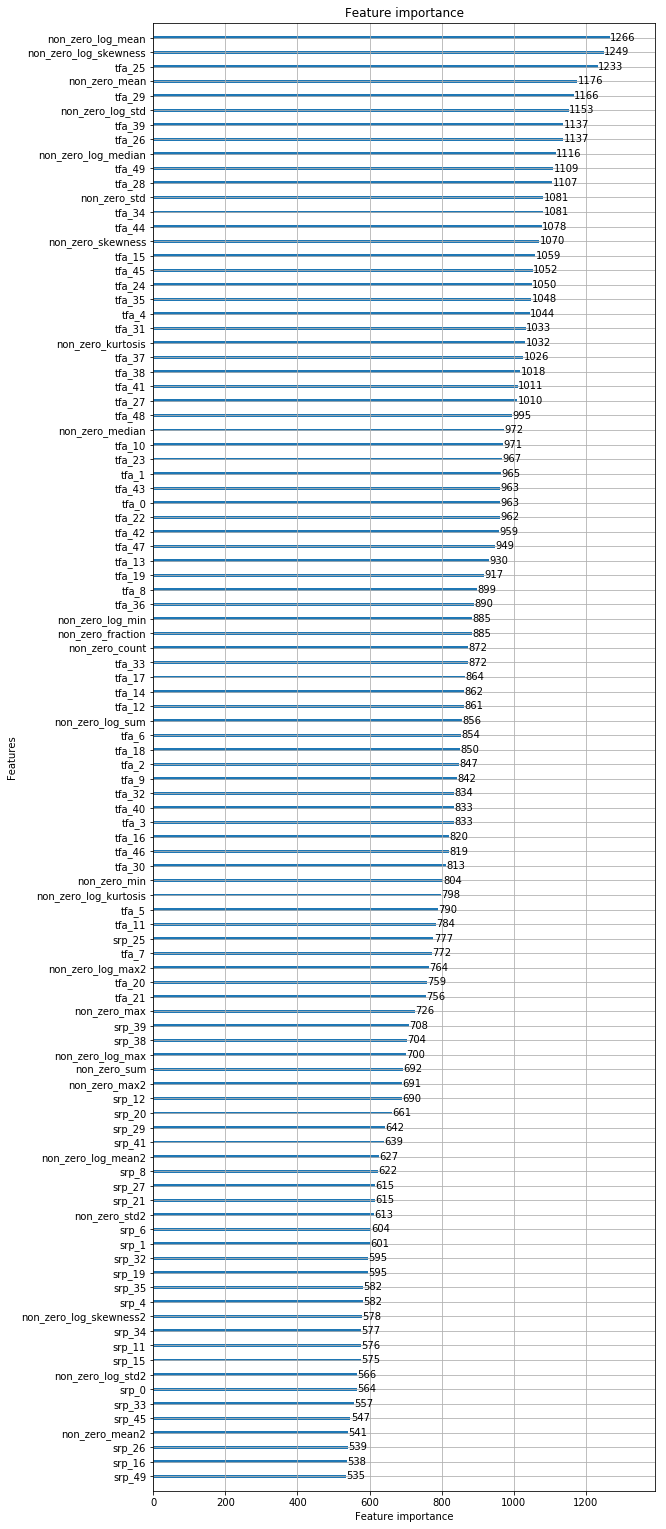

In [25]:

lgb.plot_importance(model, max_num_features=100, figsize=(9, 27))    


In [26]:
sample = pd.read_csv('input/test.csv', usecols=['ID'])
sample["target"] = sub_preds
sample.to_csv("submissions/subm_20180629_lgb2.csv", index=False)

In [29]:
subm_013 = pd.read_csv('submissions/subm_013_140.csv')
subm_012 = pd.read_csv('submissions/subm_012_140.csv')
subm_010 = pd.read_csv('submissions/subm_010_141.csv')
subm_007 = pd.read_csv('submissions/subm_007_144.csv')
subm_xgb = pd.read_csv('submissions/subm_20180629_xgb1.csv')

In [30]:
subm_013['subm_012'] = subm_012.target.values
subm_013['subm_010'] = subm_010.target.values
subm_013['subm_007'] = subm_007.target.values
subm_013['subm_xgb'] = subm_xgb.target.values


In [31]:
subm_013.corr()

,target,subm_012,subm_010,subm_007,subm_xgb
target,1.000000,0.977368,0.952674,0.682340,0.944526
subm_012,0.977368,1.000000,0.965453,0.759145,0.952605
subm_010,0.952674,0.965453,1.000000,0.656187,0.928871
subm_007,0.682340,0.759145,0.656187,1.000000,0.613136
subm_xgb,0.944526,0.952605,0.928871,0.613136,1.000000


In [33]:
subm_014 = subm_013
subm_014.target = subm_012.target * 0.5 + subm_013.target * 0.2 + subm_010.target * 0.2 + subm_xgb.target * 0.1
subm_014[['ID', 'target']].to_csv("submissions/subm_014.csv", index=False)